## Graph Convolutional Neural Network

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import numpy as np

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from lightning.pytorch import loggers as pl_loggers
import pdb 

tb_logger = pl_loggers.TensorBoardLogger(save_dir="lightning_logs")

/Users/ant746/PycharmProjects/space/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

import pytorch_lightning as pl

from spacebench import (
    SpaceEnv,
    SpaceDataset,
    DataMaster,
    DatasetEvaluator,
    EnvEvaluator,
)

envname = "healthd_dmgrcs_mortality_disc"
env = SpaceEnv(envname, dir="downloads")
env.__dict__.keys()
dataset = env.make()

from sklearn.preprocessing import StandardScaler
from torch.optim import Adam


In [3]:

class GCN(pl.LightningModule):
    def __init__(self, dim, edge_index, hidden_channels, output_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, output_channels)
        self.edge_index = edge_index

    def forward(self, data):
        x, edge_index = data.x, self.edge_index
        #pdb.set_trace() 
        x = self.conv1(x, edge_index)
        x = F.silu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        
        x = self.conv2(x, edge_index)

        return x

    def training_step(self, batch, batch_idx):
        y_hat = self.forward(batch)
        #pdb.set_trace()
        loss = F.mse_loss(y_hat, batch.y)
        self.log('train_loss', loss)  # Logs loss to TensorBoard
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat = self.forward(batch)
        loss = F.mse_loss(y_hat, batch.y)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        y_hat = self.forward(batch)
        #pdb.set_trace()
        loss = F.mse_loss(y_hat, batch.y)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), weight_decay=0.005, lr=0.001)
        return optimizer


In [4]:

treatment = dataset.treatment[:, None]
covariates = dataset.covariates
outcome = dataset.outcome.reshape(-1, 1)

# make train matrix
features = np.hstack([covariates, treatment])
# Standardize input and output data
feats_scaler = StandardScaler()
output_scaler = StandardScaler()

features = feats_scaler.fit_transform(features)
output = output_scaler.fit_transform(outcome)

In [5]:
batch_size = features.shape[0]

In [6]:
# Initialize the model and trainer
model = GCN(features.shape[1], torch.LongTensor(dataset.edges).T, hidden_channels=32, output_channels=1)
trainer = pl.Trainer(accelerator="cpu",logger=tb_logger) #gpus=1 if torch.cuda.is_available() else 0)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ant746/PycharmProjects/space/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [7]:
# from torch_geometric.transforms import RandomLinkSplit

# transform = RandomLinkSplit(is_undirected=True)
# train_data, val_data, test_data = transform(Data(x=torch.tensor(
#     features,dtype=torch.float), 
#     y=torch.tensor(output, dtype=torch.float), 
#     edge_index=torch.LongTensor(dataset.edges).T))

In [8]:
train_loader = DataLoader([Data(x=torch.tensor(
    features,dtype=torch.float), 
    y=torch.tensor(output, dtype=torch.float), 
    edge_index=torch.LongTensor(dataset.edges).T)], batch_size=batch_size, shuffle=False, num_workers=0)

In [9]:
trainer.fit(model, train_loader)

/Users/ant746/PycharmProjects/space/.venv/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/Users/ant746/PycharmProjects/space/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type    | Params
----------------------------------
0 | conv1 | GCNConv | 512   
1 | conv2 | GCNConv | 17    
----------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
/Users/ant746/PycharmProjects/space/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many w

Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 136.33it/s, v_num=8]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 103.72it/s, v_num=8]


## Predictions

In [10]:
# predict counterfactuals
tvals = dataset.treatment_values
counterfactuals = []

for tval in tvals:
    trainmat = np.hstack([covariates, np.full_like(treatment, tval)])
    trainmat = feats_scaler.transform(trainmat)
    #DataLoader([trainmat], batch_size=batch_size, shuffle=False, num_workers=0)

    cfs_loader = DataLoader([Data(
        x=torch.tensor(trainmat,dtype=torch.float),
        edge_index=torch.LongTensor(dataset.edges).T)], batch_size=batch_size, shuffle=False, num_workers=0)

    pred = trainer.predict(model, cfs_loader)

    counterfactuals.append(pred[0])
    
counterfactuals = np.stack(counterfactuals, axis=1)

/Users/ant746/PycharmProjects/space/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 315.08it/s]

/Users/ant746/PycharmProjects/space/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 332.22it/s]


In [11]:
for i in range(counterfactuals.shape[1]):
    counterfactuals[:, i] = output_scaler.inverse_transform(counterfactuals[:, i])

In [12]:
erf =counterfactuals.mean(0)

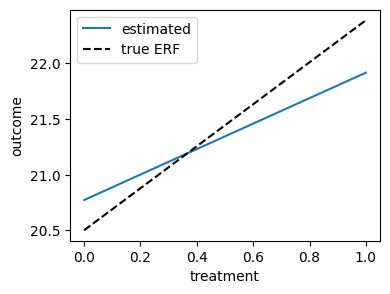

In [13]:
# plot comparing estimated and true erf
erf_true = dataset.erf()

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(dataset.treatment_values, erf, label="estimated")
ax.plot(dataset.treatment_values, erf_true, label="true ERF", linestyle="--", color="k")
ax.set_xlabel("treatment")
ax.set_ylabel("outcome")
ax.legend();